In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

def initialize_grid(Nb, Nr):
    grid = np.zeros((200, 200))
    blue_agents = np.random.choice(40000, Nb, replace=False)
    red_agents = np.random.choice([x for x in range(40000) if x not in blue_agents], Nr, replace=False)
    grid.flat[blue_agents] = 1
    grid.flat[red_agents] = -1
    return grid

def compute_fraction(grid, kernel):
    sum_neighbors_blue = convolve2d(grid == 1, kernel, mode='same', boundary='fill', fillvalue=0) # changed
    sum_neighbors_red = convolve2d(grid == -1, kernel, mode='same', boundary='fill', fillvalue=0) # changed
    total_neighbors = sum_neighbors_blue + sum_neighbors_red + 1e-6
    fraction_blue = sum_neighbors_blue / total_neighbors
    fraction_red = sum_neighbors_red / total_neighbors
    return fraction_blue, fraction_red

# def find_unhappy_cells(grid, fraction_blue, fraction_red, jt):
#     unhappy_blue = (grid == 1) & (fraction_blue < jt) 
#     unhappy_red = (grid == -1) & (fraction_red < jt)
#     return unhappy_blue | unhappy_red

def find_unhappy_cells(grid, fraction_blue, fraction_red, jt):
    # For blue agents: Unhappy if the fraction of red (unlike) agents is >= T
    unhappy_blue = (grid == 1) & (fraction_red >= jt) 
    # For red agents: Unhappy if the fraction of blue (unlike) agents is >= T
    unhappy_red = (grid == -1) & (fraction_blue >= jt)
    return unhappy_blue | unhappy_red


# def main_loop(grid, jt, max_iter):
#     kernel = np.ones((3, 3))
#     kernel[1, 1] = 0
#     age_grid = np.zeros_like(grid)  # Initialize age grid
#     iterations = 0

#     while iterations < max_iter:
#         fraction_blue, fraction_red = compute_fraction(grid, kernel)
#         unhappy_cells = find_unhappy_cells(grid, fraction_blue, fraction_red, jt)

#         moving_grid = np.zeros_like(grid)  # Initialize moving grid
#         empty_cells = (grid == 0) & (moving_grid == 0)  # Consider cells as empty if they are not reserved
#         num_unhappy = np.sum(unhappy_cells)
#         num_empty = np.sum(empty_cells)

#         age_grid[grid != 0] += 1  # Increase age for non-empty cells
#         age_grid[unhappy_cells] = 0  # Reset age for unhappy agents

#         if num_unhappy > 0 and num_empty > 0:
#             num_to_move = min(num_unhappy, num_empty)
#             new_positions = np.random.choice(np.flatnonzero(empty_cells), num_to_move, replace=False)
#             old_positions = np.random.choice(np.flatnonzero(unhappy_cells), num_to_move, replace=False)

#             # Apply aging effect on movement
#             for idx in range(num_to_move):
#                 old_fraction = fraction_blue.flat[old_positions[idx]] if grid.flat[old_positions[idx]] == 1 else fraction_red.flat[old_positions[idx]]
#                 new_fraction = fraction_blue.flat[new_positions[idx]] if grid.flat[old_positions[idx]] == 1 else fraction_red.flat[new_positions[idx]]
#                 if np.random.rand() < (1 / (2 + age_grid.flat[old_positions[idx]])) and new_fraction >= old_fraction:
#                     moving_grid.flat[new_positions[idx]] = grid.flat[old_positions[idx]]  # Reserve new position
#                     grid.flat[old_positions[idx]] = 0

#         grid += moving_grid  # Add the moving grid to the main grid to finalize the movement
#         iterations += 1

#     return iterations, grid

def main_loop(grid, jt, max_iter):
    kernel = np.ones((3, 3))
    kernel[1, 1] = 0
    age_grid = np.zeros_like(grid)  # Initialize age grid
    iterations = 0

    while iterations < max_iter:
        fraction_blue, fraction_red = compute_fraction(grid, kernel)
        unhappy_cells = find_unhappy_cells(grid, fraction_blue, fraction_red, jt)

        moving_grid = np.zeros_like(grid)  # Initialize moving grid
        empty_cells = (grid == 0)  # Consider cells as empty if they are not reserved
        num_unhappy = np.sum(unhappy_cells)
        num_empty = np.sum(empty_cells)

        if num_unhappy > 0 and num_empty > 0:
            num_to_move = min(num_unhappy, num_empty)
            new_positions = np.random.choice(np.flatnonzero(empty_cells), num_to_move, replace=False)
            old_positions = np.random.choice(np.flatnonzero(unhappy_cells), num_to_move, replace=False)

            for idx in range(num_to_move):
                old_pos = old_positions[idx]
                new_pos = new_positions[idx]

                # Check if agent is satisfied
                is_satisfied = not unhappy_cells.flat[old_pos]

                # Apply aging effect on movement
                if is_satisfied:
                    activation_probability = 1 / (age_grid.flat[old_pos] + 2)
                    if np.random.rand() < activation_probability:
                        moving_grid.flat[new_pos] = grid.flat[old_pos]  # Reserve new position
                        grid.flat[old_pos] = 0
                        age_grid.flat[old_pos] = 0  # Reset age as agent moves
                    else:
                        age_grid.flat[old_pos] += 1  # Increase age if agent does not move
                else:
                    moving_grid.flat[new_pos] = grid.flat[old_pos]  # Reserve new position for unsatisfied agent
                    grid.flat[old_pos] = 0
                    age_grid.flat[old_pos] = 0  # Reset age as agent moves

        grid += moving_grid  # Add the moving grid to the main grid to finalize the movement
        iterations += 1

    return iterations, grid


jt = 5/7
empty_space = 0.005
Nb = int((40000*(1-empty_space))/2)
Nr = int((40000*(1-empty_space))/2)


# Initialize the grid
grid_in = initialize_grid(Nb, Nr)



# New

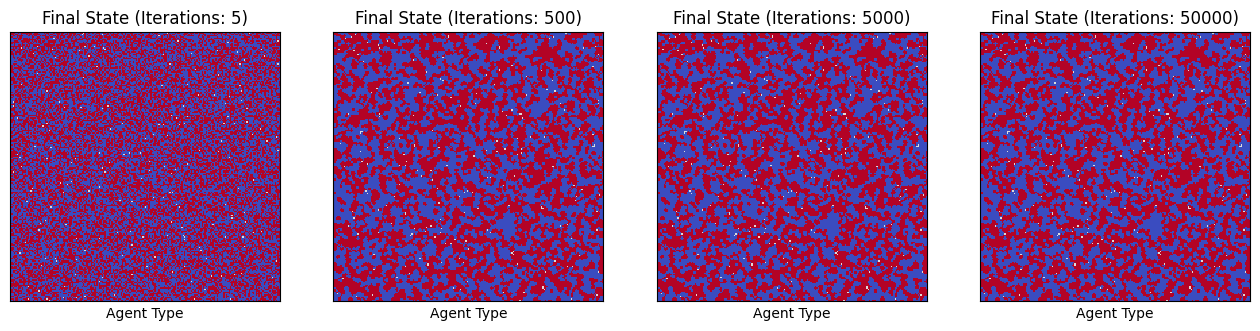

In [4]:
# Create subplots for initial and final states
fig, axes = plt.subplots(1, 4, figsize=(16,8))

iterations, grid_new = main_loop(grid_in, jt, 5)
# Display the initial state of the grid
axes[0].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1, interpolation='none')
axes[0].set_title(f'Final State (Iterations: {iterations})')
axes[0].set_xlabel('Agent Type')
axes[0].set_xticks([])
axes[0].set_yticks([])

# Run the main loop with the specified threshold and maximum iterations
iterations, grid_new = main_loop(grid_in, jt, 500)

# Display the final state of the grid
axes[1].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[1].set_title(f'Final State (Iterations: {iterations})')
axes[1].set_xlabel('Agent Type')
axes[1].set_xticks([])
axes[1].set_yticks([])

iterations, grid_new = main_loop(grid_in, jt, 5000)

# Display the final state of the grid
axes[2].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[2].set_title(f'Final State (Iterations: {iterations})')
axes[2].set_xlabel('Agent Type')
axes[2].set_xticks([])
axes[2].set_yticks([])

iterations, grid_new = main_loop(grid_in, jt, 50000)

# Display the final state of the grid
axes[3].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[3].set_title(f'Final State (Iterations: {iterations})')
axes[3].set_xlabel('Agent Type')
axes[3].set_xticks([])
axes[3].set_yticks([])

plt.show()

# Old

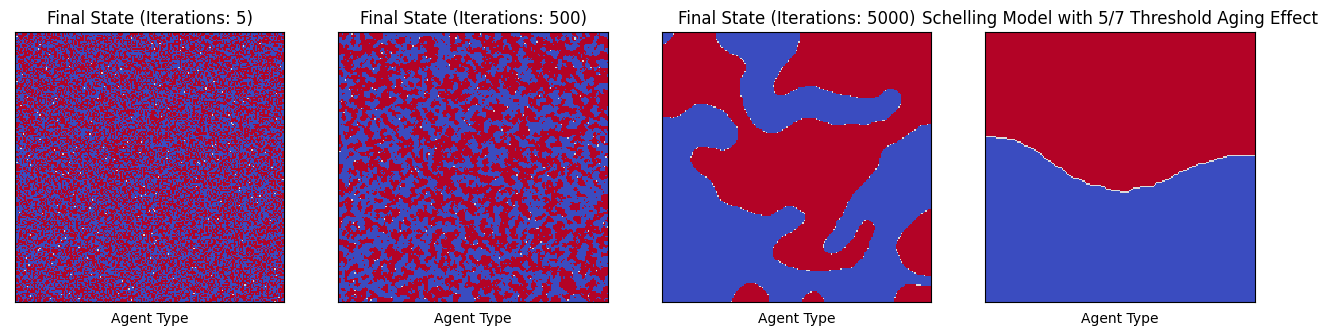

In [17]:

# Create subplots for initial and final states
fig, axes = plt.subplots(1, 4, figsize=(16,8))

iterations, grid_new = main_loop(grid_in, jt, 5)
# Display the initial state of the grid
axes[0].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1, interpolation='none')
axes[0].set_title(f'Final State (Iterations: {iterations})')
axes[0].set_xlabel('Agent Type')
axes[0].set_xticks([])
axes[0].set_yticks([])

# Run the main loop with the specified threshold and maximum iterations
iterations, grid_new = main_loop(grid_in, jt, 500)

# Display the final state of the grid
axes[1].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[1].set_title(f'Final State (Iterations: {iterations})')
axes[1].set_xlabel('Agent Type')
axes[1].set_xticks([])
axes[1].set_yticks([])

iterations, grid_new = main_loop(grid_in, jt, 5000)

# Display the final state of the grid
axes[2].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[2].set_title(f'Final State (Iterations: {iterations})')
axes[2].set_xlabel('Agent Type')
axes[2].set_xticks([])
axes[2].set_yticks([])

iterations, grid_new = main_loop(grid_in, jt, 50000)

# Display the final state of the grid
axes[3].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[3].set_title(f'Final State (Iterations: {iterations})')
axes[3].set_xlabel('Agent Type')
axes[3].set_xticks([])
axes[3].set_yticks([])

plt.show()



In [18]:

# Initialize the grid
grid_in = initialize_grid(Nb, Nr)

jt = 6/7 
empty_space = 0.005
Nb = int((40000*(1-empty_space))/2)
Nr = int((40000*(1-empty_space))/2)

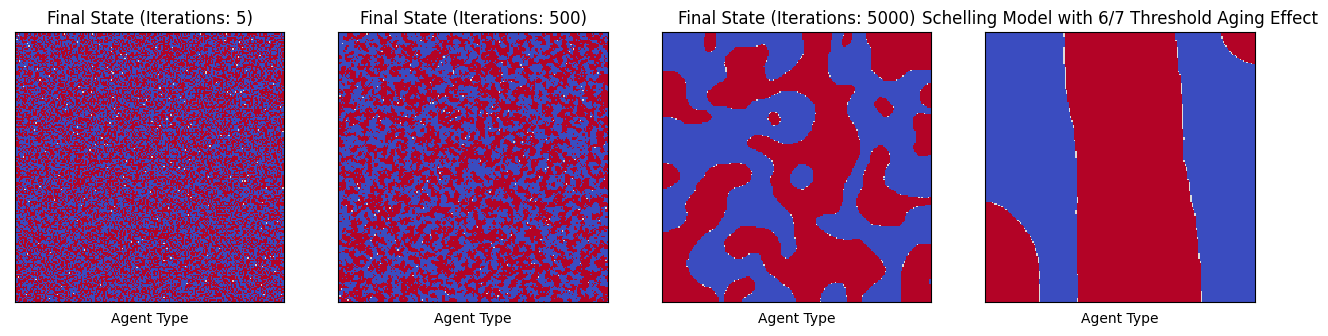

In [19]:

# Create subplots for initial and final states
fig, axes = plt.subplots(1, 4, figsize=(16,8))

iterations, grid_new = main_loop(grid_in, jt, 5)
# Display the initial state of the grid
axes[0].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1, interpolation='none')
axes[0].set_title(f'Final State (Iterations: {iterations})')
axes[0].set_xlabel('Agent Type')
axes[0].set_xticks([])
axes[0].set_yticks([])

# Run the main loop with the specified threshold and maximum iterations
iterations, grid_new = main_loop(grid_in, jt, 500)

# Display the final state of the grid
axes[1].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[1].set_title(f'Final State (Iterations: {iterations})')
axes[1].set_xlabel('Agent Type')
axes[1].set_xticks([])
axes[1].set_yticks([])

iterations, grid_new = main_loop(grid_in, jt, 5000)

# Display the final state of the grid
axes[2].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[2].set_title(f'Final State (Iterations: {iterations})')
axes[2].set_xlabel('Agent Type')
axes[2].set_xticks([])
axes[2].set_yticks([])

iterations, grid_new = main_loop(grid_in, jt, 50000)

# Display the final state of the grid
axes[3].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[3].set_title(f'Final State (Iterations: {iterations})')
axes[3].set_xlabel('Agent Type')
axes[3].set_xticks([])
axes[3].set_yticks([])


plt.show()



#### no aging

In [20]:
###without aging
# main loop
def main_loop(grid, jt, max_iter):
    kernel = np.ones((3, 3))
    kernel[1, 1] = 0
    iterations = 0

    while iterations < max_iter:
        fraction_blue, fraction_red = compute_fraction(grid, kernel)
        unhappy_cells = find_unhappy_cells(grid, fraction_blue, fraction_red, jt)

        moving_grid = np.zeros_like(grid)  # Initialize moving grid
        empty_cells = (grid == 0) & (moving_grid == 0)  # Consider cells as empty if they are not reserved
        num_unhappy = np.sum(unhappy_cells)
        num_empty = np.sum(empty_cells)

        if num_unhappy > 0 and num_empty > 0:
            num_to_move = min(num_unhappy, num_empty)
            new_positions = np.random.choice(np.flatnonzero(empty_cells), num_to_move, replace=False)
            old_positions = np.random.choice(np.flatnonzero(unhappy_cells), num_to_move, replace=False)

            for idx in range(num_to_move):
                moving_grid.flat[new_positions[idx]] = grid.flat[old_positions[idx]]  # Reserve new position
                grid.flat[old_positions[idx]] = 0

        grid += moving_grid  # Add the moving grid to the main grid to finalize the movement
        iterations += 1

    return iterations, grid



In [21]:
# Initialize the grid
grid_in = initialize_grid(Nb, Nr)

jt = 5/7
empty_space = 0.005
Nb = int((40000*(1-empty_space))/2)
Nr = int((40000*(1-empty_space))/2)



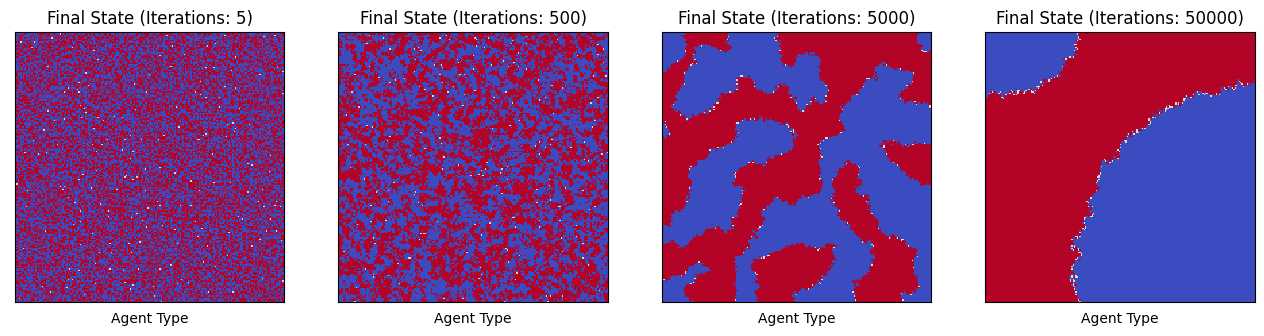

In [22]:
#plotting
# Create subplots for initial and final states
fig, axes = plt.subplots(1, 4, figsize=(16,8))

iterations, grid_new = main_loop(grid_in, jt, 5)
# Display the initial state of the grid
axes[0].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1, interpolation='none')
axes[0].set_title(f'Final State (Iterations: {iterations})')
axes[0].set_xlabel('Agent Type')
axes[0].set_xticks([])
axes[0].set_yticks([])


# Run the main loop with the specified threshold and maximum iterations
iterations, grid_new = main_loop(grid_in, jt, 500)

# Display the final state of the grid
axes[1].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[1].set_title(f'Final State (Iterations: {iterations})')
axes[1].set_xlabel('Agent Type')
axes[1].set_xticks([])
axes[1].set_yticks([])

iterations, grid_new = main_loop(grid_in, jt, 5000)

axes[2].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[2].set_title(f'Final State (Iterations: {iterations})')
axes[2].set_xlabel('Agent Type')
axes[2].set_xticks([])
axes[2].set_yticks([])

iterations, grid_new = main_loop(grid_in, jt, 50000)
axes[3].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[3].set_title(f'Final State (Iterations: {iterations})')
axes[3].set_xlabel('Agent Type')
axes[3].set_xticks([])
axes[3].set_yticks([])


plt.show()


In [23]:
# Initialize the grid
grid_in = initialize_grid(Nb, Nr)

jt = 4/7
empty_space = 0.005
Nb = int((40000*(1-empty_space))/2)
Nr = int((40000*(1-empty_space))/2)


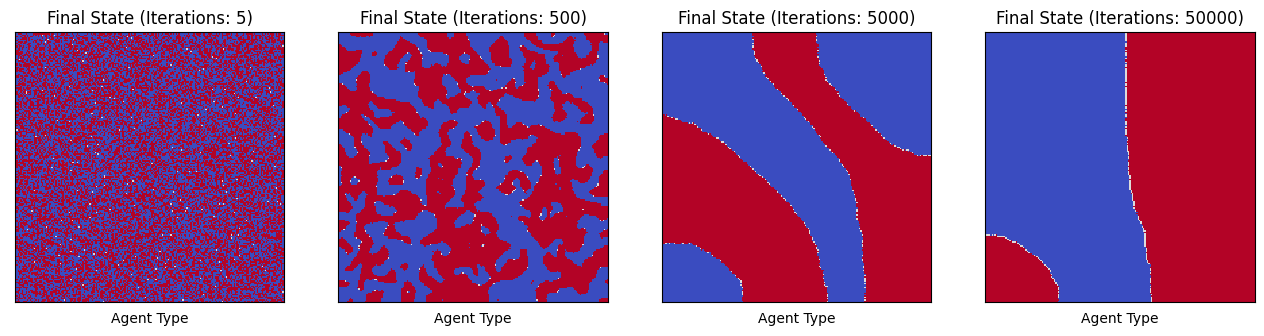

In [24]:
fig, axes = plt.subplots(1, 4, figsize=(16,8))

iterations, grid_new = main_loop(grid_in, jt, 5)
# Display the initial state of the grid
axes[0].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1, interpolation='none')
axes[0].set_title(f'Final State (Iterations: {iterations})')
axes[0].set_xlabel('Agent Type')
axes[0].set_xticks([])
axes[0].set_yticks([])


# Run the main loop with the specified threshold and maximum iterations
iterations, grid_new = main_loop(grid_in, jt, 500)

# Display the final state of the grid
axes[1].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[1].set_title(f'Final State (Iterations: {iterations})')
axes[1].set_xlabel('Agent Type')
axes[1].set_xticks([])
axes[1].set_yticks([])

iterations, grid_new = main_loop(grid_in, jt, 5000)

axes[2].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[2].set_title(f'Final State (Iterations: {iterations})')
axes[2].set_xlabel('Agent Type')
axes[2].set_xticks([])
axes[2].set_yticks([])

iterations, grid_new = main_loop(grid_in, jt, 50000)
axes[3].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[3].set_title(f'Final State (Iterations: {iterations})')
axes[3].set_xlabel('Agent Type')
axes[3].set_xticks([])
axes[3].set_yticks([])


plt.show()

#### Test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

def initialize_grid(Nb, Nr):
    grid = np.zeros((200, 200))
    blue_agents = np.random.choice(40000, Nb, replace=False)
    red_agents = np.random.choice([x for x in range(40000) if x not in blue_agents], Nr, replace=False)
    grid.flat[blue_agents] = 1
    grid.flat[red_agents] = -1
    return grid

def compute_fraction(grid, kernel):
    sum_neighbors_blue = convolve2d(grid == 1, kernel, mode='same', boundary='fill', fillvalue=0)
    sum_neighbors_red = convolve2d(grid == -1, kernel, mode='same', boundary='fill', fillvalue=0)
    total_neighbors = sum_neighbors_blue + sum_neighbors_red + 1e-6
    fraction_blue = sum_neighbors_blue / total_neighbors
    fraction_red = sum_neighbors_red / total_neighbors
    return fraction_blue, fraction_red

def find_unhappy_cells(grid, fraction_blue, fraction_red, jt):
    unhappy_blue = (grid == 1) & (fraction_blue < jt) 
    unhappy_red = (grid == -1) & (fraction_red < jt)
    return unhappy_blue | unhappy_red

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

def initialize_grid(Nb, Nr):
    grid = np.zeros((200, 200))
    blue_agents = np.random.choice(40000, Nb, replace=False)
    red_agents = np.random.choice([x for x in range(40000) if x not in blue_agents], Nr, replace=False)
    grid.flat[blue_agents] = 1
    grid.flat[red_agents] = -1
    return grid

def compute_fraction(grid, kernel):
    sum_neighbors_blue = convolve2d(grid == 1, kernel, mode='same', boundary='fill', fillvalue=0)
    sum_neighbors_red = convolve2d(grid == -1, kernel, mode='same', boundary='fill', fillvalue=0)
    total_neighbors = sum_neighbors_blue + sum_neighbors_red + 1e-6
    fraction_blue = sum_neighbors_blue / total_neighbors
    fraction_red = sum_neighbors_red / total_neighbors
    return fraction_blue, fraction_red

def find_unhappy_cells(grid, fraction_blue, fraction_red, jt):
    unhappy_blue = (grid == 1) & (fraction_blue < jt) 
    unhappy_red = (grid == -1) & (fraction_red < jt)
    return unhappy_blue | unhappy_red


def main_loop(grid, jt, max_iter):
    kernel = np.ones((3, 3))
    kernel[1, 1] = 0
    age_grid = np.zeros_like(grid)  # Initialize age grid
    iterations = 0

    # ...
# ...
# ...
    while iterations < max_iter:
        fraction_blue, fraction_red = compute_fraction(grid, kernel)
        unhappy_cells = find_unhappy_cells(grid, fraction_blue, fraction_red, jt)

        moving_grid = np.zeros_like(grid)  # Initialize moving grid
        empty_cells = (grid == 0) & (moving_grid == 0)  # Consider cells as empty if they are not reserved
        num_unhappy = np.sum(unhappy_cells)
        num_empty = np.sum(empty_cells)

        age_grid[grid != 0] += 1  # Increase age for non-empty cells
        age_grid[unhappy_cells] = 0  # Reset age for unhappy agents

        if num_unhappy > 0 and num_empty > 0:
            num_to_move = min(num_unhappy, num_empty)

            # Define old_positions and new_positions inside the loop
            old_positions = np.random.choice(np.flatnonzero(unhappy_cells), num_to_move, replace=False)
            new_positions = np.zeros_like(old_positions)

            for idx in range(num_to_move):
                new_positions_candidates = np.flatnonzero(empty_cells)
                satisfying_positions = new_positions_candidates[(fraction_blue.flat[new_positions_candidates] if grid.flat[old_positions[idx]] == 1 else fraction_red.flat[new_positions_candidates]) >= jt]

                if len(satisfying_positions) > 0:
                    new_positions[idx] = np.random.choice(satisfying_positions)
                else:
                    new_positions[idx] = np.random.choice(new_positions_candidates)

                # Apply aging effect on movement
                if np.random.rand() < (1 / (2 + age_grid.flat[old_positions[idx]])):
                    moving_grid.flat[new_positions[idx]] = grid.flat[old_positions[idx]]  # Reserve new position
                    grid.flat[old_positions[idx]] = 0

        grid += moving_grid  # Add the moving grid to the main grid to finalize the movement
        iterations += 1
    # ...

# ...

# ...


    return iterations, grid





In [41]:
# Initialize the grid

jt = 5/7
empty_space = 0.005
Nb = int((40000*(1-empty_space))/2)
Nr = int((40000*(1-empty_space))/2)

grid_in = initialize_grid(Nb, Nr)

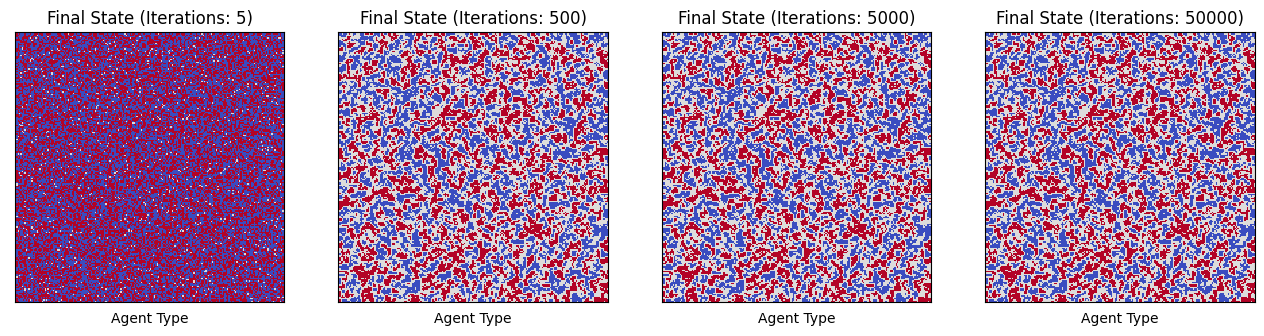

In [42]:

# Create subplots for initial and final states
fig, axes = plt.subplots(1, 4, figsize=(16,8))

iterations, grid_new = main_loop(grid_in, jt, 5)
# Display the initial state of the grid
axes[0].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1, interpolation='none')
axes[0].set_title(f'Final State (Iterations: {iterations})')
axes[0].set_xlabel('Agent Type')
axes[0].set_xticks([])
axes[0].set_yticks([])

# Run the main loop with the specified threshold and maximum iterations
iterations, grid_new = main_loop(grid_in, jt, 500)

# Display the final state of the grid
axes[1].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[1].set_title(f'Final State (Iterations: {iterations})')
axes[1].set_xlabel('Agent Type')
axes[1].set_xticks([])
axes[1].set_yticks([])

iterations, grid_new = main_loop(grid_in, jt, 5000)

# Display the final state of the grid
axes[2].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[2].set_title(f'Final State (Iterations: {iterations})')
axes[2].set_xlabel('Agent Type')
axes[2].set_xticks([])
axes[2].set_yticks([])

iterations, grid_new = main_loop(grid_in, jt, 50000)

# Display the final state of the grid
axes[3].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[3].set_title(f'Final State (Iterations: {iterations})')
axes[3].set_xlabel('Agent Type')
axes[3].set_xticks([])
axes[3].set_yticks([])

plt.show()



#### 6/7

In [7]:
jt = 6/7-0.01
empty_space = 0.05
Nb = int((40000*(1-empty_space))/2)
Nr = int((40000*(1-empty_space))/2)


# Initialize the grid
grid_in = initialize_grid(Nb, Nr)

In [8]:

# Create subplots for initial and final states
fig, axes = plt.subplots(1, 4, figsize=(16,8))

iterations, grid_new = main_loop(grid_in, jt, 5)
# Display the initial state of the grid
axes[0].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1, interpolation='none')
axes[0].set_title(f'Final State (Iterations: {iterations})')
axes[0].set_xlabel('Agent Type')
axes[0].set_xticks([])
axes[0].set_yticks([])

# Run the main loop with the specified threshold and maximum iterations
iterations, grid_new = main_loop(grid_in, jt, 500)

# Display the final state of the grid
axes[1].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[1].set_title(f'Final State (Iterations: {iterations})')
axes[1].set_xlabel('Agent Type')
axes[1].set_xticks([])
axes[1].set_yticks([])

iterations, grid_new = main_loop(grid_in, jt, 5000)

# Display the final state of the grid
axes[2].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[2].set_title(f'Final State (Iterations: {iterations})')
axes[2].set_xlabel('Agent Type')
axes[2].set_xticks([])
axes[2].set_yticks([])

iterations, grid_new = main_loop(grid_in, jt, 50000)

# Display the final state of the grid
axes[3].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[3].set_title(f'Final State (Iterations: {iterations})')
axes[3].set_xlabel('Agent Type')
axes[3].set_xticks([])
axes[3].set_yticks([])

plt.show()

